In [3]:
import torch
import ot
import geoopt
# import scipy.linalg
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import trange
from geoopt import linalg
from pyriemann.datasets import sample_gaussian_spd, generate_random_spd_matrix

sys.path.append("./lib")
from utils_spd import busemann_spd
# from logm import logm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Busemann

In [7]:
theta = torch.randn(1000, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [8]:
M = torch.eye(2, device=device)
M = M.reshape((1, 2, 2))
M = M.repeat(10, 1, 1)

## Compute logM in advance since we cannot batch it
# log_M = torch.zeros(M.shape, device=device)
# for k in range(len(log_M)):
#     log_M[k] = logm(M[k])
log_M = linalg.sym_logm(M)

In [9]:
b = busemann_spd(log_M, dA)

In [10]:
print(log_M.shape, dA.shape)
print(b.shape)

torch.Size([10, 2, 2]) torch.Size([1000, 2, 2])
torch.Size([10, 1000])


In [11]:
b

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], device='cuda:0')

In [12]:
ts = torch.linspace(-10,10,200).to(device)
ts = ts.reshape(ts.shape[0],1,1)
ts = ts.repeat(1,2,2)

In [18]:
theta = torch.randn(3, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [19]:
M = torch.linalg.matrix_exp(ts[:,None]*A[None])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [6, 2, 2], which does not match the required output shape [1, 6, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [34, 2, 2], which does not match the required output shape [1, 34, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Tri

In [20]:
print(ts.shape, A.shape, M.shape)

torch.Size([200, 2, 2]) torch.Size([3, 2, 2]) torch.Size([200, 3, 2, 2])


In [21]:
L = np.zeros((ts.shape[0],M.shape[1],A.shape[0]))

for i, t in enumerate(ts):
    # log_M = torch.zeros(M[i].shape, device=device)
    # for k in range(len(log_M)):
    #     log_M[k] = logm(M[i][k])
    
    log_M = linalg.sym_logm(M[i])
    b = busemann_spd(log_M, dA)
    L[i] = b.detach().cpu()

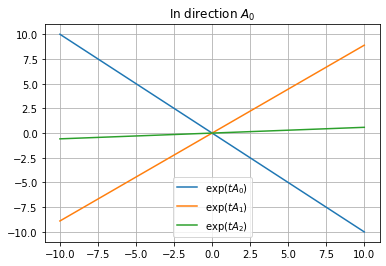

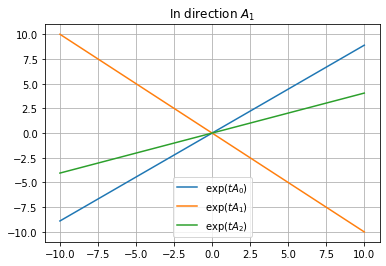

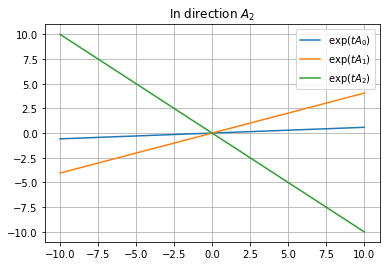

In [22]:
for i in range(A.shape[0]):
    for k in range(3):
        plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$\exp(t A_"+str(k)+r")$")
    plt.title(r"In direction $A_"+str(i)+r"$")
    plt.legend()
    plt.grid(True)
    plt.show()

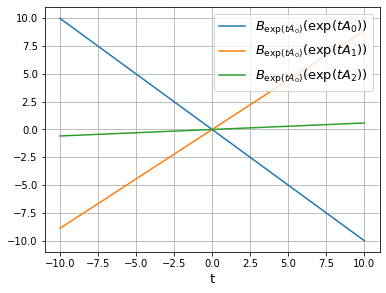

In [36]:
i = 0

fig = plt.figure(figsize=(6,4.5))

for k in range(3):
    plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$B_{\exp(tA_0)}(\exp(t A_"+str(k)+r"))$")

plt.xlabel("t", fontsize=13)
# plt.title(r"In direction $A_"+str(i)+r"$", fontsize=13)
plt.legend(fontsize=13, loc="upper right")
plt.grid(True)
plt.savefig("./Busemann_along_geodesics.pdf", format="pdf", bbox_inches="tight")
plt.show()